In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [4]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [5]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    massprefac = -1/(m1+m3)
    w2 = massprefac*(alpha23**(5/2)*m1*m2/ec23**2 + alpha12**(1/2)*m2*m3/ec12**2 + alpha12**(1/2)*alpha23**(5/2)*(m1+m3)**2/ec13**2)
    w1 = massprefac*(m_tot * (alpha23**(5/2)*m3/ec23**2 + alpha12**(1/2)*m1/ec12**2))
    k = massprefac * np.sqrt(m1*m2*m3*m_tot) * (alpha23**(5/2)*1/ec23**2 - alpha12**(1/2)*1/ec12**2)
    
    phi = 1/2*np.arctan2(2*k, w2-w1)
    R1 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = np.matmul(R1, R2)
    
    print('Theoretical rotation matrix is')
    print(T.T)
    print('Calculated rotation matrix is')
    print(R)

    Sxapprox = R @ Gx.T
    Syapprox = R @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a, S2a, S3a = np.sqrt(Sxapprox**2 + Syapprox**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

In [6]:
def norun(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
     
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    massprefac = -1/(m1+m3)
    w2 = massprefac*(alpha23**(5/2)*m1*m2/ec23**2 + alpha12**(1/2)*m2*m3/ec12**2 + alpha12**(1/2)*alpha23**(5/2)*(m1+m3)**2/ec13**2)
    w1 = massprefac*(m_tot * (alpha23**(5/2)*m3/ec23**2 + alpha12**(1/2)*m1/ec12**2))
    k = massprefac * np.sqrt(m1*m2*m3*m_tot) * (alpha23**(5/2)*1/ec23**2 - alpha12**(1/2)*1/ec12**2)

    phi = 1/2*np.arctan2(2*k, w2-w1)
    R1 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R1@R2
    
    print('Theoretical rotation matrix is')
    print(T.T)
    print('Calculated rotation matrix is')
    print(R)
    
    print('-------------------------------------------------------------')
    print('Mdiag eigenvals:', Mdiag[0][0],Mdiag[1][1],Mdiag[2][2])
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    Mp = R1 @ Mdiagapprox @ R1.T
    print('Mapprox eigenvals:', Mp[0][0],Mp[1][1],Mp[2][2])
    print('Error:', (Mdiag[0][0]-Mp[0][0])/Mdiag[0][0], (Mdiag[1][1]-Mp[1][1])/Mdiag[1][1], (Mdiag[2][2]-Mp[2][2])/Mdiag[2][2])
    
    print('-------------------------------------------------------------')
    print('w1:', Mdiagapprox[0,0], w1, (Mdiagapprox[0,0]-w1)/Mdiagapprox[0,0])
    print('w2:', Mdiagapprox[1,1], w2, (Mdiagapprox[1,1]-w2)/Mdiagapprox[1,1])
    print('w2-w1:', Mdiagapprox[1,1]-Mdiagapprox[0,0], w2-w1, ((Mdiagapprox[1,1]-Mdiagapprox[0,0])-(w2-w1))/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    print('k:', Mdiagapprox[1,0], k, (Mdiagapprox[1,0]-k)/Mdiagapprox[1,0])
    
    angle = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    print('phi:', angle, phi, (angle-phi)/angle)

In [7]:
alpha = 0.76, 0.78
mass = 1e-7,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
norun(sim)

Theoretical rotation matrix is
[[ 0.49191518 -0.81138505  0.31571151]
 [ 0.6960801   0.14870638 -0.70239512]
 [-0.52296459 -0.56527932 -0.63793991]]
Calculated rotation matrix is
[[ 0.51794812 -0.80559761  0.2876495 ]
 [-0.63118651 -0.13296297  0.76414948]
 [ 0.57735027  0.57735027  0.57735027]]
-------------------------------------------------------------
Mdiag eigenvals: -3.962559499804242e-06 -1.8794885624322108e-06 -2.874702169457529e-07
Mapprox eigenvals: -3.959437158589142e-06 -1.87183405067921e-06 -2.98247069913852e-07
Error: 0.0007879607145973506 0.004072656735455359 -0.03748858954015664
-------------------------------------------------------------
w1: -3.929968036854164e-06 -3.935520173671863e-06 -0.0014127689501880218
w2: -1.9013031724141874e-06 -1.87685200646187e-06 0.012860214145264589
w2-w1: 2.028664864439977e-06 2.058668167209993e-06 -0.01478967930875988
k: 2.5912026909223435e-07 3.4929606124144234e-07 -0.3480074811017958
phi: 0.1250549178410019 0.16357418753926917 -0.308

In [8]:
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

Theoretical rotation matrix is
[[ 0.49191518 -0.81138505  0.31571151]
 [ 0.6960801   0.14870638 -0.70239512]
 [-0.52296459 -0.56527932 -0.63793991]]
Calculated rotation matrix is
[[ 0.51793973 -0.80559938  0.28765965]
 [-0.6311934  -0.13295226  0.76414566]
 [ 0.57735027  0.57735027  0.57735027]]


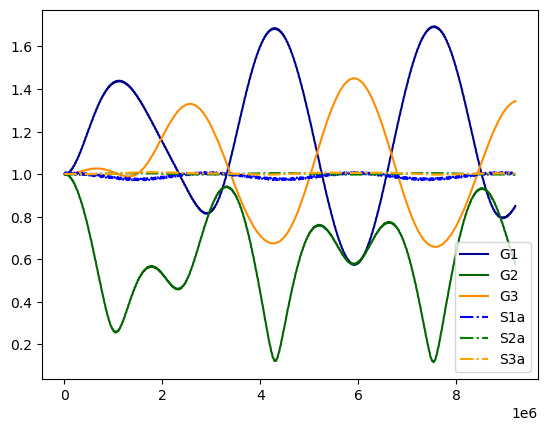

In [9]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1/S1[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2/S2[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

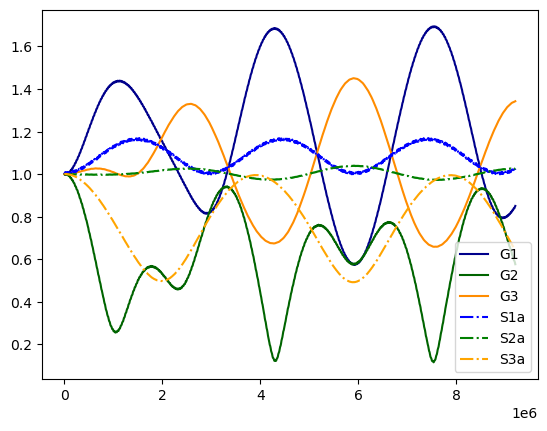

In [10]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

In [11]:
alpha = 0.76, 0.85
mass = 1e-6,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
norun(sim)

Theoretical rotation matrix is
[[ 0.21566048 -0.95010349  0.22537505]
 [-0.32478238  0.14787136  0.93415762]
 [ 0.92087293  0.27465873  0.27668687]]
Calculated rotation matrix is
[[ 0.23728871 -0.95058383  0.20021103]
 [-0.33220586  0.11426747  0.93625969]
 [ 0.91287093  0.28867513  0.28867513]]
-------------------------------------------------------------
Mdiag eigenvals: -1.9085679522292067e-05 -7.320973524977785e-06 -5.727975233660152e-07
Mapprox eigenvals: -1.907161784693211e-05 -7.3305160574480835e-06 -5.773166662556644e-07
Error: 0.0007367657695150386 -0.0013034513016255255 -0.007889599213161184
-------------------------------------------------------------
w1: -1.8818232393998503e-05 -1.9740609958100186e-05 -0.04901510114179731
w2: -7.5839015103816876e-06 -7.926251355436778e-06 -0.045141652299471986
w2-w1: 1.1234330883616816e-05 1.1814358602663408e-05 -0.051629930171671834
k: -1.744404562926377e-06 -1.440998861525519e-06 0.17393081160706836
phi: -0.1505531849991411 -0.11963364907

In [12]:
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

Theoretical rotation matrix is
[[ 0.21566048 -0.95010349  0.22537505]
 [-0.32478238  0.14787136  0.93415762]
 [ 0.92087293  0.27465873  0.27668687]]
Calculated rotation matrix is
[[ 0.2372701  -0.95057742  0.20026349]
 [-0.33221915  0.11432074  0.93624847]
 [ 0.91287093  0.28867513  0.28867513]]


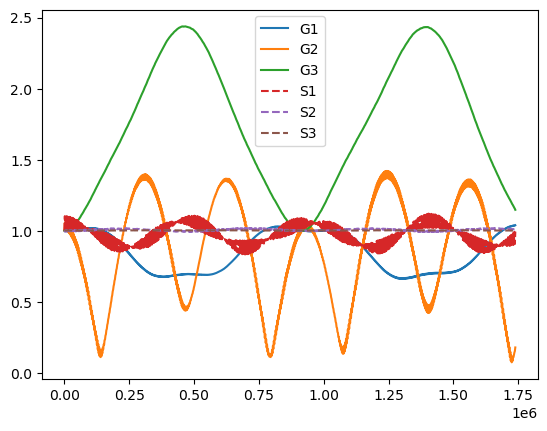

In [13]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], label='G1')
ax.plot(times, G2/G2[0], label='G2')
ax.plot(times, G3/G3[0], label='G3')
ax.plot(times, S1/S1[0], linestyle='--', label='S1')
ax.plot(times, S2/S2[0], linestyle='--', label='S2')
ax.plot(times, S3/S3[0], linestyle='--', label='S3')
ax.legend()

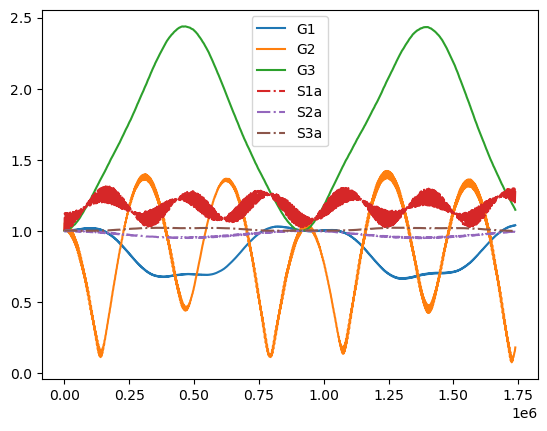

In [14]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], label='G1')
ax.plot(times, G2/G2[0], label='G2')
ax.plot(times, G3/G3[0], label='G3')
ax.plot(times, S1a/S1a[0], linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], linestyle='-.', label='S3a')
ax.legend()